In [1]:
import pandas as pd
import numpy as np

#preprocess
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from missingpy import KNNImputer

#feature selection
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE

#model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor

#evaluation
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

import warnings
warnings.filterwarnings('ignore')

import importlib
import sys
sys.path.insert(1, '../util_funcs')

import model_evaluation_funcs as me
import feature_selection_funcs as fs

importlib.reload(me)
importlib.reload(fs)

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [2]:
np.random.seed(0)

In [3]:
original_df = pd.read_csv('Walmart.csv')

# Exploratory Data Analysis

In [4]:
original_df.head()

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

In [5]:
original_df.describe()

Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.099862e+05      0.000000    -2.060000     2.472000   
25%      12.000000  5.533501e+05      0.000000    47.460000     2.933000   
50%      23.000000  9.607460e+05      0.000000    62.670000     3.445000   
75%      34.000000  1.420159e+06      0.000000    74.940000     3.735000   
max      45.000000  3.818686e+06      1.000000   100.140000     4.468000   

               CPI  Unemployment  
count  6435.000000   6435.000000  
mean    171.578394      7.999151  
std      39.356712      1.875885  
min     126.064000      3.879000  
25%     131.735000      6.891000  
50%     182.616521      7.874000  
75%     212.743293      8.622000  
max     227.232807     14.313000

In [6]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [7]:
original_df['Date'] = pd.to_datetime(original_df.Date)

In [8]:
df = original_df.drop('Date', axis=1)
df.columns = df.columns.str.lower()

df.head()

store  weekly_sales  holiday_flag  temperature  fuel_price         cpi  \
0      1    1643690.90             0        42.31       2.572  211.096358   
1      1    1641957.44             1        38.51       2.548  211.242170   
2      1    1611968.17             0        39.93       2.514  211.289143   
3      1    1409727.59             0        46.63       2.561  211.319643   
4      1    1554806.68             0        46.50       2.625  211.350143   

   unemployment  
0         8.106  
1         8.106  
2         8.106  
3         8.106  
4         8.106

In [9]:
df['year'] = original_df.Date.dt.year
df['month'] = original_df.Date.dt.month
df['day'] = original_df.Date.dt.weekday

df.head()

store  weekly_sales  holiday_flag  temperature  fuel_price         cpi  \
0      1    1643690.90             0        42.31       2.572  211.096358   
1      1    1641957.44             1        38.51       2.548  211.242170   
2      1    1611968.17             0        39.93       2.514  211.289143   
3      1    1409727.59             0        46.63       2.561  211.319643   
4      1    1554806.68             0        46.50       2.625  211.350143   

   unemployment  year  month  day  
0         8.106  2010      5    6  
1         8.106  2010     12    3  
2         8.106  2010      2    4  
3         8.106  2010      2    4  
4         8.106  2010      5    0

In [10]:
target = 'weekly_sales'
features = df.filter(regex='^(?!weekly_sales)').columns

print('Target column: ', target)
print('Feature columns: ', ', '.join(features))

Target column:  weekly_sales
Feature columns:  store, holiday_flag, temperature, fuel_price, cpi, unemployment, year, month, day


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         6435 non-null   int64  
 1   weekly_sales  6435 non-null   float64
 2   holiday_flag  6435 non-null   int64  
 3   temperature   6435 non-null   float64
 4   fuel_price    6435 non-null   float64
 5   cpi           6435 non-null   float64
 6   unemployment  6435 non-null   float64
 7   year          6435 non-null   int64  
 8   month         6435 non-null   int64  
 9   day           6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB


In [12]:
df.nunique()

store             45
weekly_sales    6435
holiday_flag       2
temperature     3528
fuel_price       892
cpi             2145
unemployment     349
year               3
month             12
day                7
dtype: int64

In [13]:
cat_features = ['store', 'holiday_flag', 'year', 'month', 'day']
num_features = df.columns[~df.columns.isin(cat_features+[target])]

In [14]:
sns.set_palette('rainbow_r')

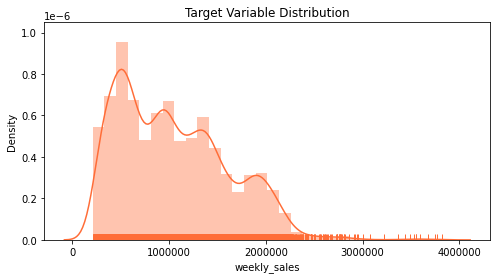

In [15]:
plt.figure(figsize=[8,4])
sns.distplot(df['weekly_sales'] , rug=True, bins=30
            )
plt.ticklabel_format(style='plain', axis='x')
plt.title('Target Variable Distribution')
plt.show()

In [16]:
cat_features

['store', 'holiday_flag', 'year', 'month', 'day']

<AxesSubplot:xlabel='holiday_flag', ylabel='count'>

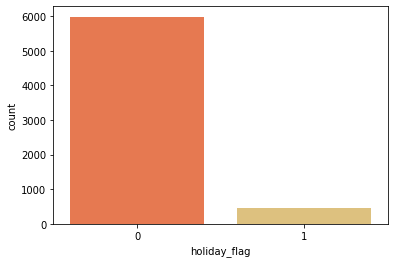

In [17]:
sns.countplot(df['holiday_flag'])

<AxesSubplot:xlabel='year', ylabel='count'>

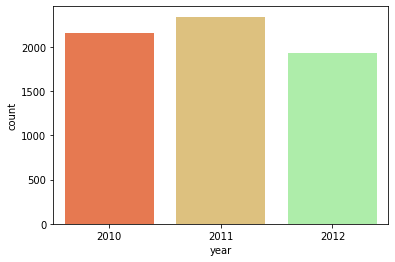

In [18]:
sns.countplot(df['year'])

<AxesSubplot:xlabel='month', ylabel='count'>

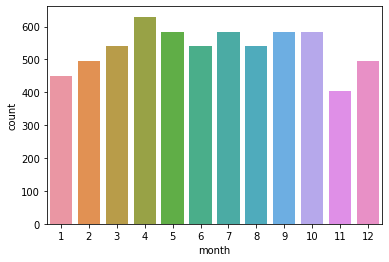

In [19]:
sns.countplot(df['month'])

<AxesSubplot:xlabel='day', ylabel='count'>

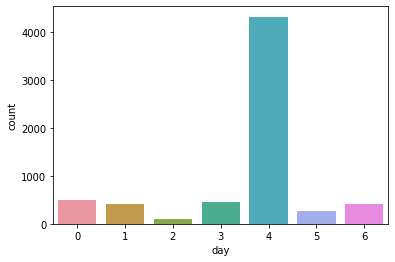

In [20]:
sns.countplot(df['day'])

<AxesSubplot:xlabel='store', ylabel='count'>

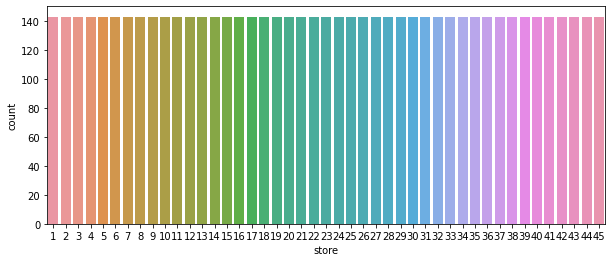

In [21]:
plt.figure(figsize=[10,4])
sns.countplot(df['store'])

#### Distribution of Continuous Variables

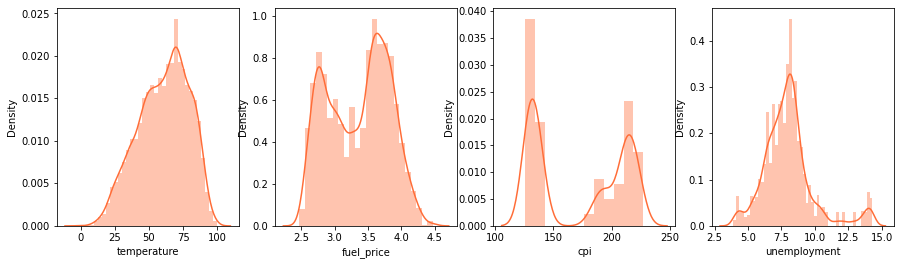

In [133]:
ncols=4
fig, ax = plt.subplots(nrows=int(np.ceil(len(num_features)/ncols)), ncols=ncols, figsize=[15,4])
for i in range(len(num_features)):
    sns.distplot(x=df[num_features[i]], ax=ax.flat[i], axlabel=num_features[i])
plt.show()

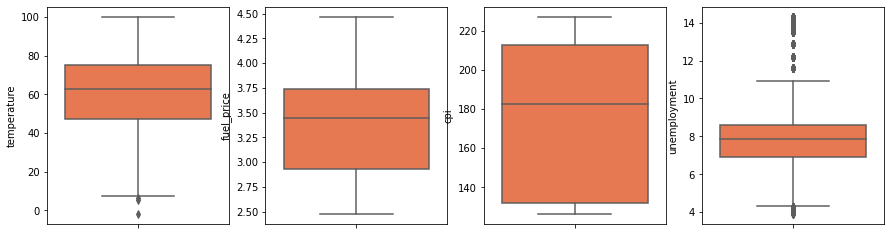

In [134]:
ncols=4
fig, ax = plt.subplots(nrows=int(np.ceil(len(num_features)/ncols)), ncols=ncols, figsize=[15,4])
for i in range(len(num_features)):
    sns.boxplot(y=df[num_features[i]], ax=ax.flat[i])
plt.show()

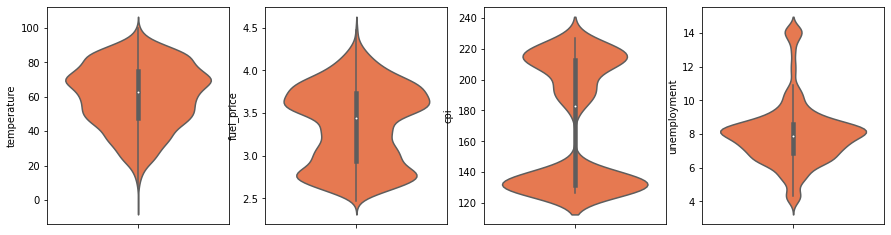

In [24]:
ncols=4
fig, ax = plt.subplots(nrows=int(np.ceil(len(num_features)/ncols)), ncols=ncols, figsize=[15,4])
for i in range(len(num_features)):
    sns.violinplot(y=df[num_features[i]], ax=ax.flat[i])
plt.show()

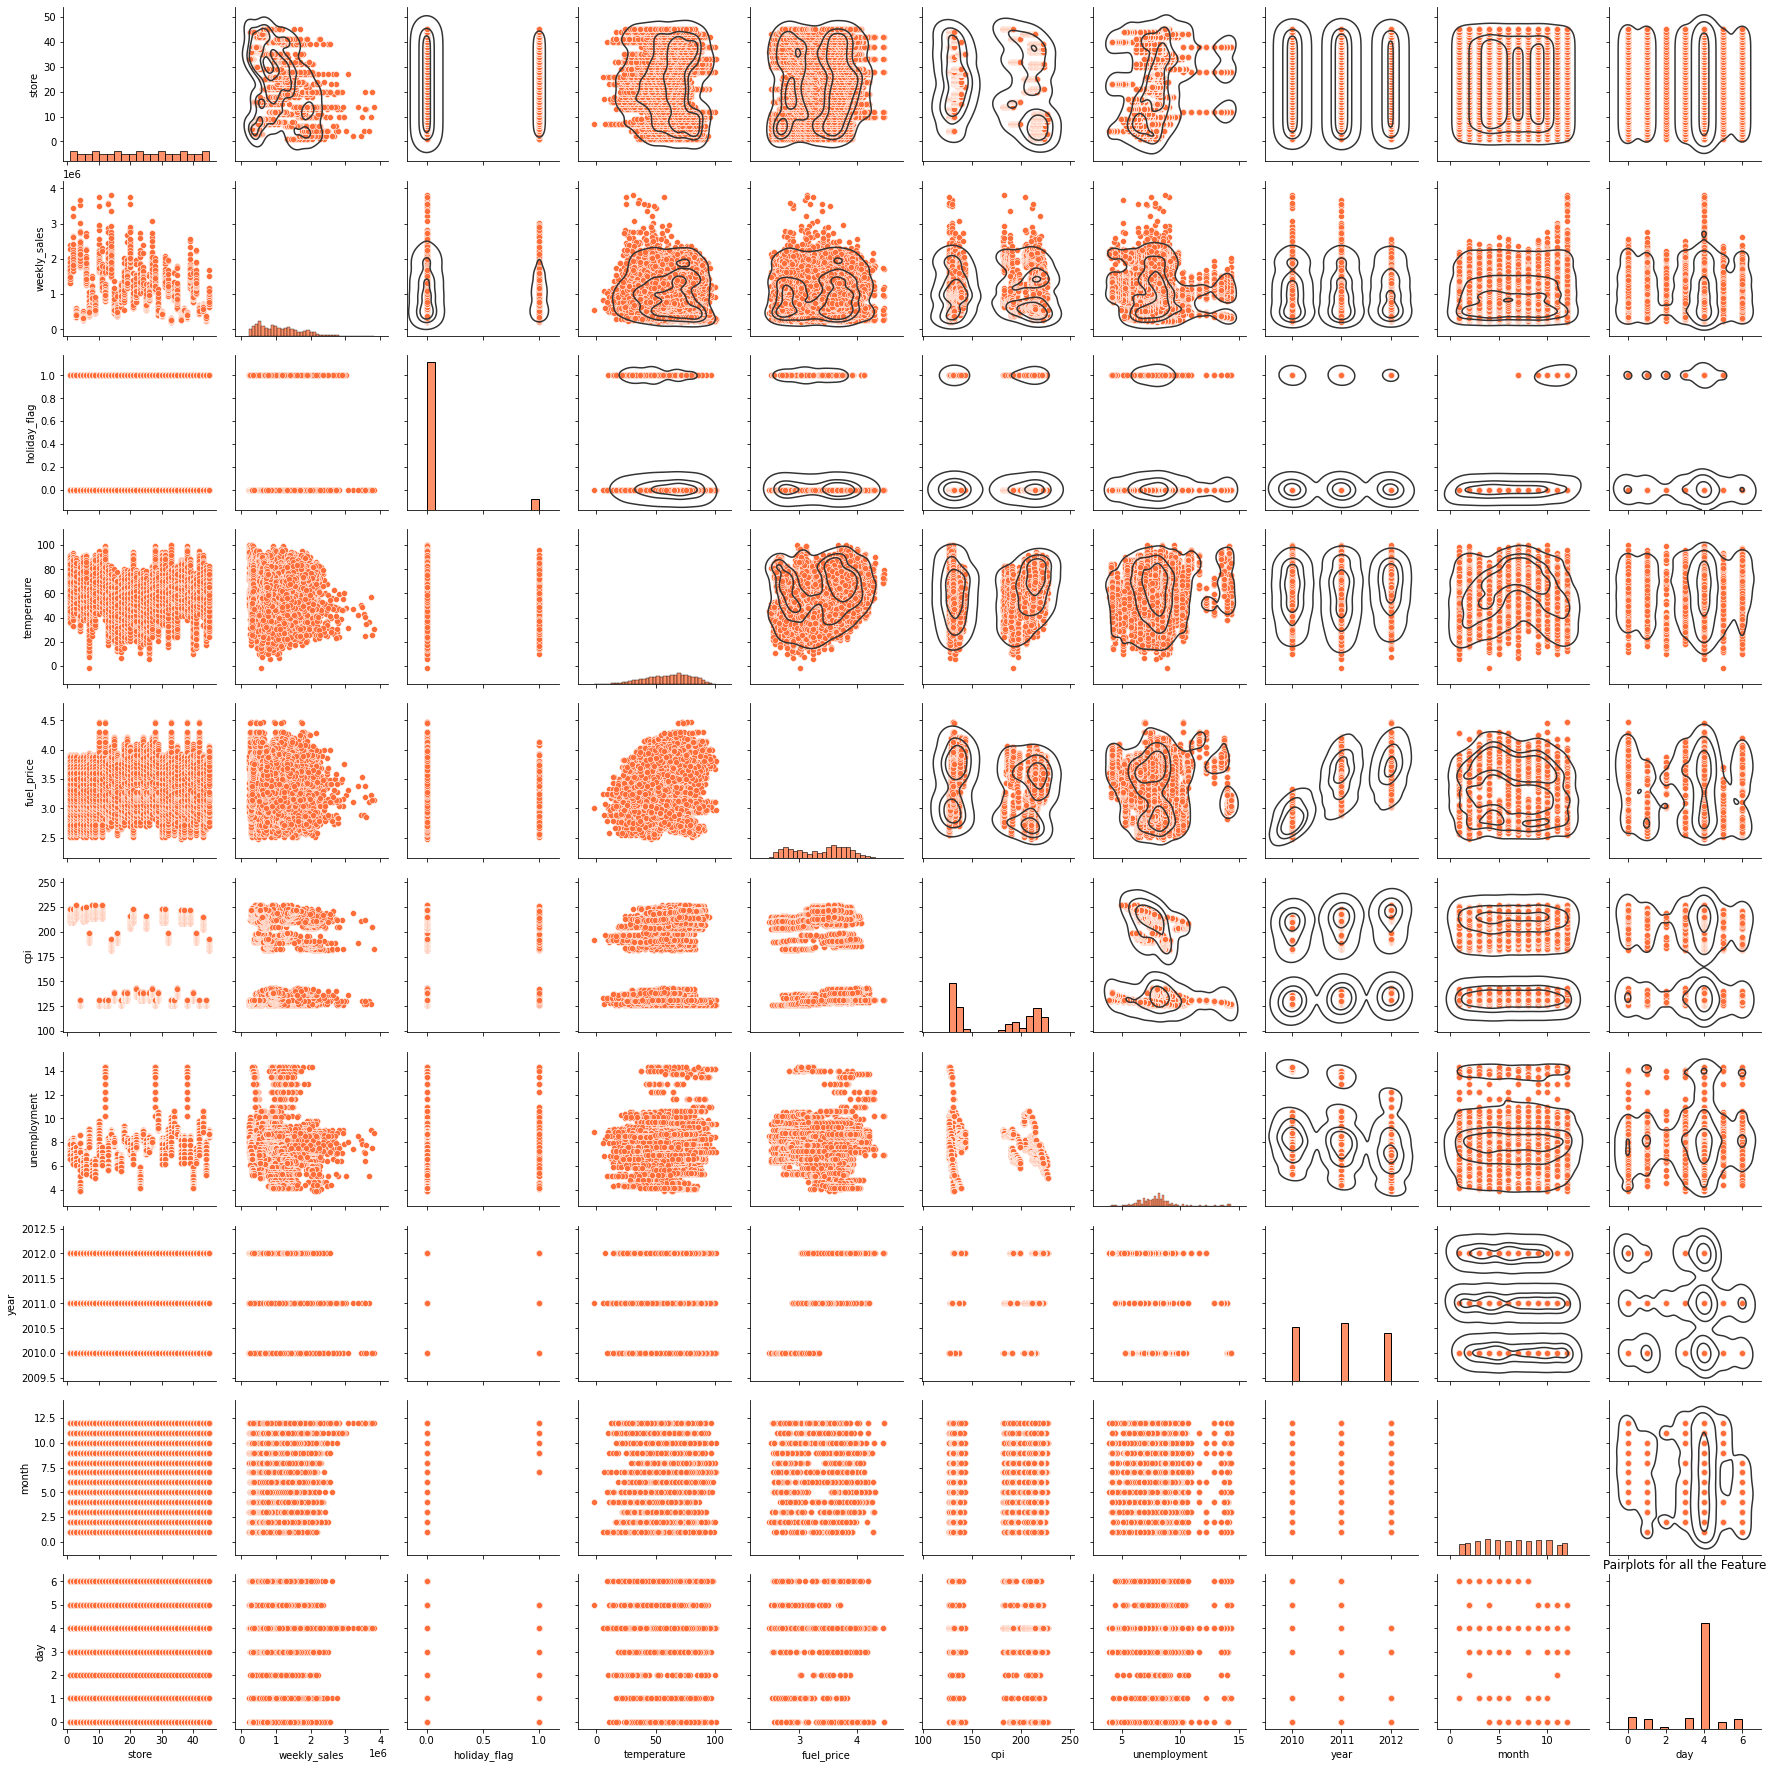

In [25]:
g = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

In [26]:
df.duplicated().sum()

0

In [27]:
df[[i for i in cat_features if 'flag' not in i]] = df[[i for i in cat_features if 'flag' not in i]].astype(str)

In [28]:
df = pd.concat([df, pd.get_dummies(df[[i for i in cat_features if 'flag' not in i]], prefix_sep='_')], 
               axis=1).drop(
    ['store', 'day', 'month', 'year'], axis=1)

In [29]:
df.shape

(6435, 73)

In [30]:
df.columns

Index(['weekly_sales', 'holiday_flag', 'temperature', 'fuel_price', 'cpi',
       'unemployment', 'store_1', 'store_10', 'store_11', 'store_12',
       'store_13', 'store_14', 'store_15', 'store_16', 'store_17', 'store_18',
       'store_19', 'store_2', 'store_20', 'store_21', 'store_22', 'store_23',
       'store_24', 'store_25', 'store_26', 'store_27', 'store_28', 'store_29',
       'store_3', 'store_30', 'store_31', 'store_32', 'store_33', 'store_34',
       'store_35', 'store_36', 'store_37', 'store_38', 'store_39', 'store_4',
       'store_40', 'store_41', 'store_42', 'store_43', 'store_44', 'store_45',
       'store_5', 'store_6', 'store_7', 'store_8', 'store_9', 'year_2010',
       'year_2011', 'year_2012', 'month_1', 'month_10', 'month_11', 'month_12',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')

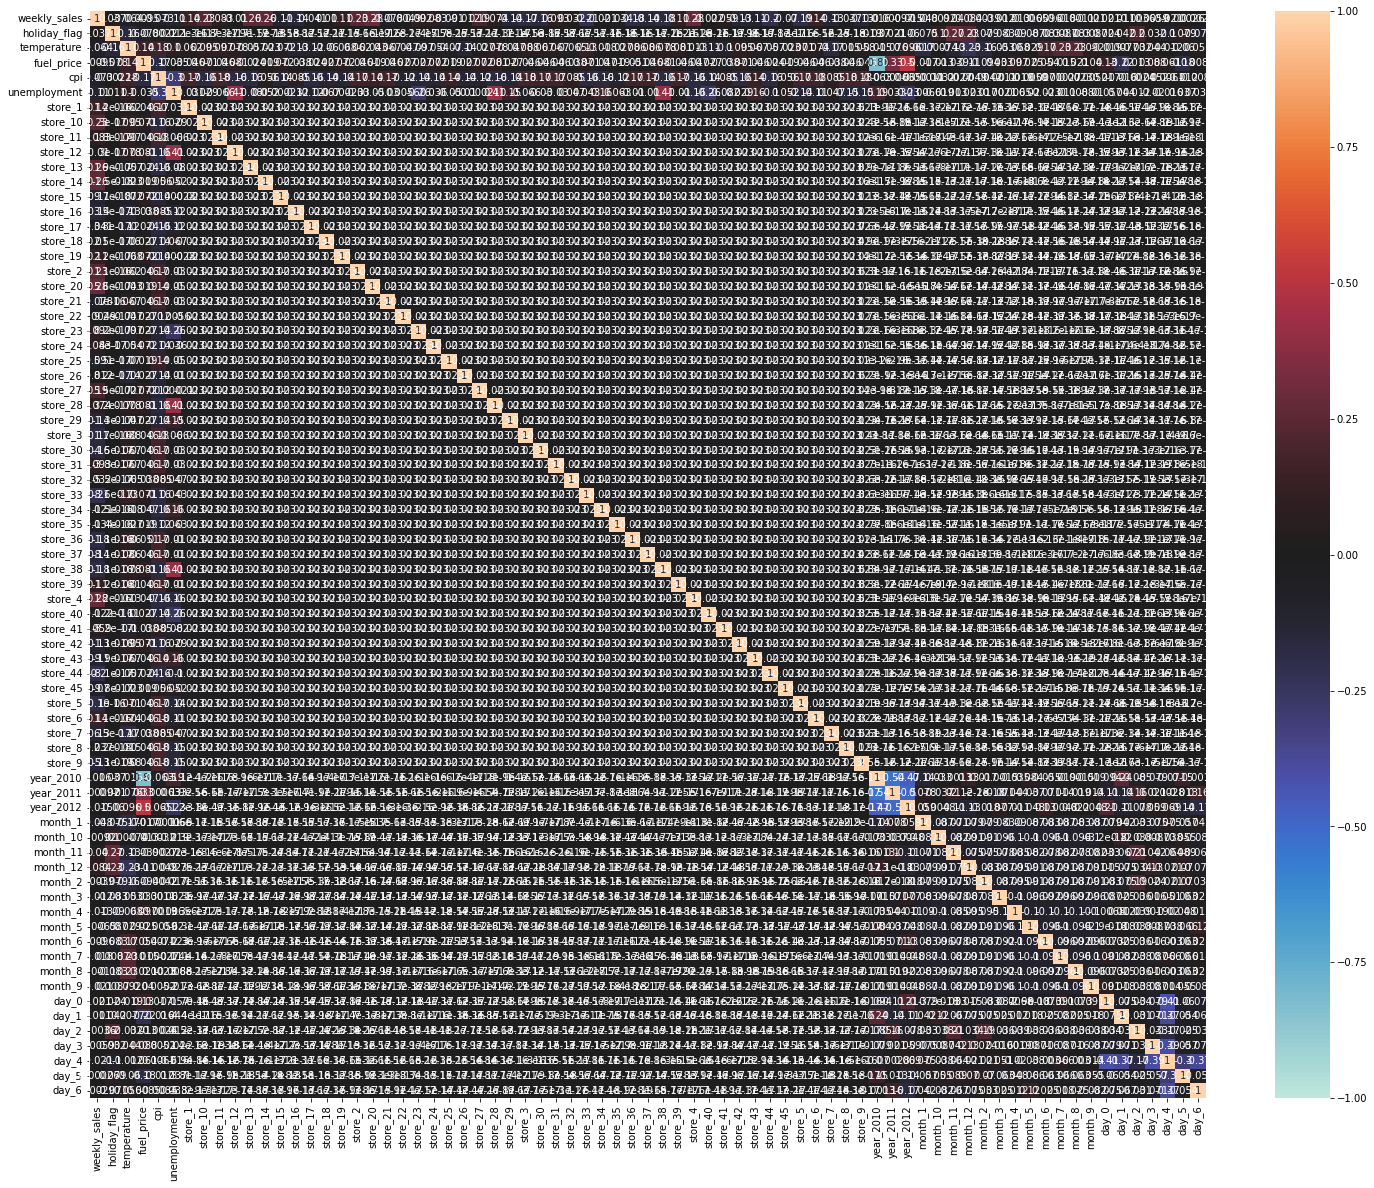

In [31]:
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

## Train test split & Preprocessing

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('weekly_sales', axis=1), df.weekly_sales, 
                                                    train_size=0.8, test_size=0.2)

In [33]:
X_tr_org, X_te_org, y_tr_org, y_te_org = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

### Univariate Outlier Detection

In [34]:
iqr_dict = {}
for i in num_features:
    q1 = X_train[i].quantile(.25)
    q3 = X_train[i].quantile(.75)
    iqr = q3-q1
    
    y_train = y_train[(X_train[i]<=q3+(1.5*iqr))&(X_train[i]>=q1-(1.5*iqr))]
    X_train = X_train[(X_train[i]<=q3+(1.5*iqr))&(X_train[i]>=q1-(1.5*iqr))]
    
    iqr_dict[i] = [q1,q3]

temperature       1
unemployment    400
dtype: int64

In [37]:
print(y_train.shape)
print(X_train.shape)

(4747,)
(4747, 72)


In [38]:
std = StandardScaler()

X_train_std = pd.DataFrame(std.fit_transform(X_train), columns=X_train.columns)
X_test_std = pd.DataFrame(std.transform(X_test), columns=X_test.columns)

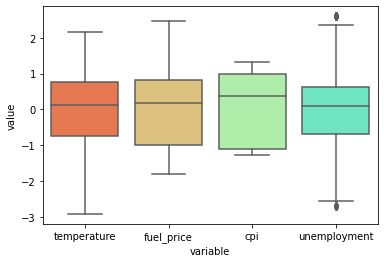

In [39]:
sns.boxplot(x="variable", y="value", data=pd.melt(X_train_std.filter(regex='^(?!store|year|month|day|holiday)')))

plt.show()

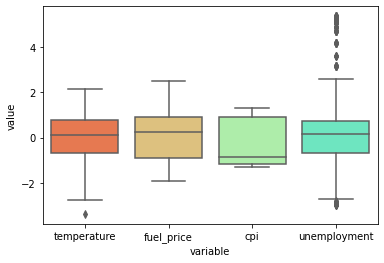

In [40]:
sns.boxplot(x="variable", y="value", data=pd.melt(X_test_std.filter(regex='^(?!store|year|month|day|holiday)')))

plt.show()

In [41]:
pd.set_option('display.max_rows', 1000)

In [42]:
X_train_std.describe().round(3).T

count  mean  std    min    25%    50%    75%     max
holiday_flag  4747.0  -0.0  1.0 -0.279 -0.279 -0.279 -0.279   3.589
temperature   4747.0  -0.0  1.0 -2.919 -0.736  0.111  0.778   2.153
fuel_price    4747.0   0.0  1.0 -1.806 -0.987  0.169  0.811   2.484
cpi           4747.0  -0.0  1.0 -1.270 -1.097  0.384  0.982   1.322
unemployment  4747.0   0.0  1.0 -2.698 -0.685  0.097  0.620   2.601
store_1       4747.0   0.0  1.0 -0.157 -0.157 -0.157 -0.157   6.375
store_10      4747.0   0.0  1.0 -0.161 -0.161 -0.161 -0.161   6.210
store_11      4747.0  -0.0  1.0 -0.155 -0.155 -0.155 -0.155   6.433
store_12      4747.0  -0.0  1.0 -0.052 -0.052 -0.052 -0.052  19.083
store_13      4747.0   0.0  1.0 -0.157 -0.157 -0.157 -0.157   6.375
store_14      4747.0   0.0  1.0 -0.157 -0.157 -0.157 -0.157   6.375
store_15      4747.0   0.0  1.0 -0.157 -0.157 -0.157 -0.157   6.375
store_16      4747.0  -0.0  1.0 -0.155 -0.155 -0.155 -0.155   6.433
store_17      4747.0  -0.0  1.0 -0.158 -0.158 -0.158 -0.158   6.318
store_18      4747.0  -0.0  1.0 -0.158 -0.158 -0.158 -0.158   6.318
store_19      4747.0   0.0  1.0 -0.152 -0.152 -0.152 -0.152   6.585
store_2       4747.0  -0.0  1.0 -0.155 -0.155 -0.155 -0.155   6.433
store_20      4747.0   0.0  1.0 -0.160 -0.160 -0.160 -0.160   6.263
store_21      4747.0  -0.0  1.0 -0.163 -0.163 -0.163 -0.163   6.131
store_22      4747.0  -0.0  1.0 -0.155 -0.155 -0.155 -0.155   6.463
store_23      4747.0  -0.0  1.0 -0.128 -0.128 -0.128 -0.128   7.788
store_24      4747.0   0.0  1.0 -0.159 -0.159 -0.159 -0.159   6.291
store_25      4747.0  -0.0  1.0 -0.155 -0.155 -0.155 -0.155   6.433
store_26      4747.0   0.0  1.0 -0.157 -0.157 -0.157 -0.157   6.375
store_27      4747.0  -0.0  1.0 -0.160 -0.160 -0.160 -0.160   6.236
store_28      4747.0   0.0  1.0 -0.058 -0.058 -0.058 -0.058  17.196
store_29      4747.0  -0.0  1.0 -0.158 -0.158 -0.158 -0.158   6.318
store_3       4747.0   0.0  1.0 -0.159 -0.159 -0.159 -0.159   6.291
store_30      4747.0  -0.0  1.0 -0.158 -0.158 -0.158 -0.158   6.347
store_31      4747.0  -0.0  1.0 -0.155 -0.155 -0.155 -0.155   6.433
store_32      4747.0  -0.0  1.0 -0.155 -0.155 -0.155 -0.155   6.433
store_33      4747.0   0.0  1.0 -0.154 -0.154 -0.154 -0.154   6.493
store_34      4747.0   0.0  1.0 -0.153 -0.153 -0.153 -0.153   6.554
store_35      4747.0  -0.0  1.0 -0.153 -0.153 -0.153 -0.153   6.523
store_36      4747.0   0.0  1.0 -0.160 -0.160 -0.160 -0.160   6.263
store_37      4747.0  -0.0  1.0 -0.160 -0.160 -0.160 -0.160   6.236
store_38      4747.0  -0.0  1.0 -0.056 -0.056 -0.056 -0.056  17.761
store_39      4747.0   0.0  1.0 -0.162 -0.162 -0.162 -0.162   6.183
store_4       4747.0   0.0  1.0 -0.130 -0.130 -0.130 -0.130   7.687
store_40      4747.0   0.0  1.0 -0.123 -0.123 -0.123 -0.123   8.115
store_41      4747.0   0.0  1.0 -0.157 -0.157 -0.157 -0.157   6.375
store_42      4747.0  -0.0  1.0 -0.153 -0.153 -0.153 -0.153   6.523
store_43      4747.0  -0.0  1.0 -0.160 -0.160 -0.160 -0.160   6.236
store_44      4747.0  -0.0  1.0 -0.158 -0.158 -0.158 -0.158   6.347
store_45      4747.0  -0.0  1.0 -0.155 -0.155 -0.155 -0.155   6.463
store_5       4747.0  -0.0  1.0 -0.163 -0.163 -0.163 -0.163   6.131
store_6       4747.0   0.0  1.0 -0.162 -0.162 -0.162 -0.162   6.183
store_7       4747.0   0.0  1.0 -0.153 -0.153 -0.153 -0.153   6.523
store_8       4747.0  -0.0  1.0 -0.158 -0.158 -0.158 -0.158   6.347
store_9       4747.0   0.0  1.0 -0.160 -0.160 -0.160 -0.160   6.263
year_2010     4747.0  -0.0  1.0 -0.718 -0.718 -0.718  1.392   1.392
year_2011     4747.0  -0.0  1.0 -0.762 -0.762 -0.762  1.312   1.312
year_2012     4747.0   0.0  1.0 -0.642 -0.642 -0.642  1.557   1.557
month_1       4747.0  -0.0  1.0 -0.274 -0.274 -0.274 -0.274   3.647
month_10      4747.0  -0.0  1.0 -0.318 -0.318 -0.318 -0.318   3.148
month_11      4747.0   0.0  1.0 -0.264 -0.264 -0.264 -0.264   3.783
month_12      4747.0   0.0  1.0 -0.290 -0.290 -0.290 -0.290   3.450
month_2       4747.0  -0.0  1.0 -0.292 -0.292 -0.292 -0.292   3.429
mon

### Feature Selection - Variance Inflation Factor

Dropped Features -->  ['store_38', 'day_6', 'month_3', 'year_2012', 'cpi', 'store_5', 'year_2010', 'unemployment']


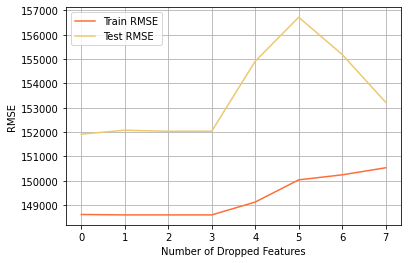

In [44]:
cols_to_drop = fs.vif_for_regression(X_train_std, X_test_std, y_train, y_test)

### Feature Selection - Recursive Feature Elimination

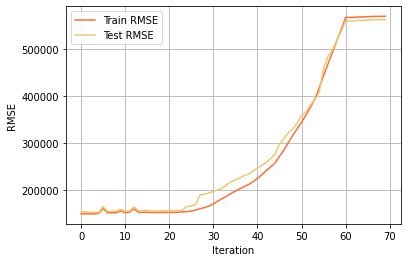

In [45]:
rfe_df = fs.rfe_for_regression(X_train_std, X_test_std, y_train, y_test)

### Feature Selection - PCA

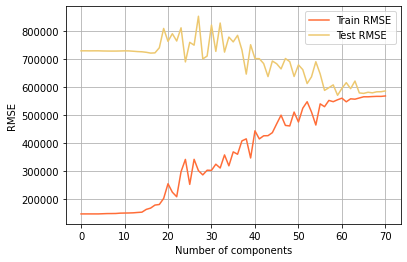

In [46]:
fs.pca_for_regression(X_train_std, X_test_std, y_train, y_test)

# Models

## Linear Regression

---------------------------------------- Linear Regression ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.9318654082015941
Root Mean Squared Error           :  149105.19847837658
Explained Variance Score          :  0.9318662586541574
Mean Absolute Error               :  91471.7686247744
Mean Squared Error                :  22232360213.27607
Mean Absolute Percentage Error    :  0.09639167982704576
Mean Squared Logarithmic Error    :  0.01872207650441308 

-----Train Set Plots-----


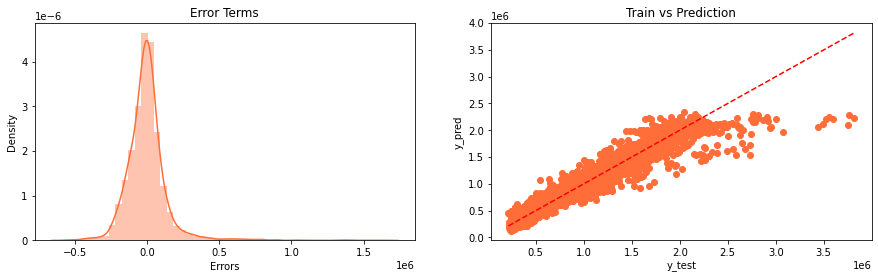

-----Test Set Metrics-----
R-squared                         :  0.9249223597486231
Root Mean Squared Error           :  149105.19847837658
Explained Variance Score          :  0.9250847283358014
Mean Absolute Error               :  93785.6338103861
Mean Squared Error                :  23729221939.55406
Mean Absolute Percentage Error    :  0.0943448760435976
Mean Squared Logarithmic Error    :  0.018428779962780494 

-----Test Set Plots-----


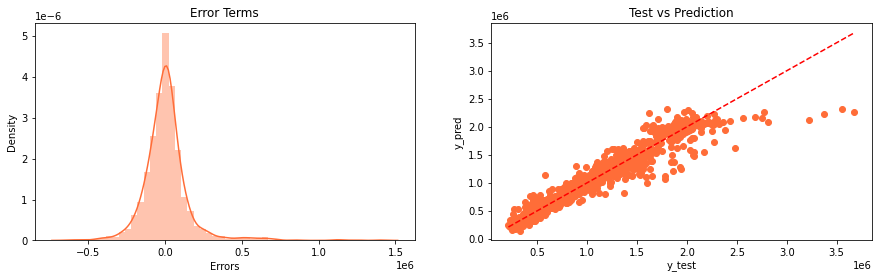

In [81]:
MLR = LinearRegression().fit(X_train_std,y_train)
pred_train = MLR.predict(X_train_std)
pred_test = MLR.predict(X_test_std)

model_evaluation_df = me.regression_evaluation('Linear Regression', y_test, pred_test, y_train, pred_train)

## Ridge Regression

---------------------------------------- Ridge Regression ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.9322829866731667
Root Mean Squared Error           :  148647.58354921715
Explained Variance Score          :  0.9322829866731667
Mean Absolute Error               :  90149.21465271832
Mean Squared Error                :  22096104095.021492
Mean Absolute Percentage Error    :  0.09522451622841069
Mean Squared Logarithmic Error    :  0.01829491480283203 

-----Train Set Plots-----


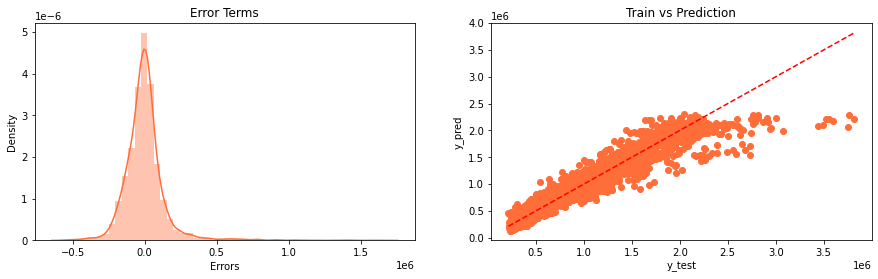

-----Test Set Metrics-----
R-squared                         :  0.9262044488908173
Root Mean Squared Error           :  148647.58354921715
Explained Variance Score          :  0.9263473783206557
Mean Absolute Error               :  92563.44398156066
Mean Squared Error                :  23324001720.863724
Mean Absolute Percentage Error    :  0.09340215891086757
Mean Squared Logarithmic Error    :  0.01787954610487934 

-----Test Set Plots-----


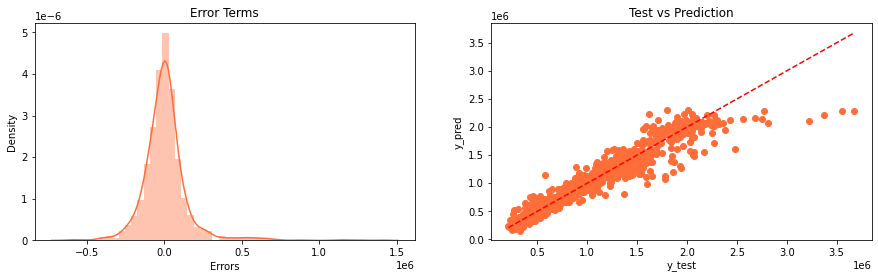

In [82]:
RLR = Ridge().fit(X_train_std,y_train)
pred_train = RLR.predict(X_train_std)
pred_test = RLR.predict(X_test_std)

model_evaluation_df.loc['Ridge Regression', : ] = (me.regression_evaluation('Ridge Regression',
                                                                            y_test, pred_test, 
                                                                            y_train, pred_train)).values[0]

## Lasso Regression

---------------------------------------- Lasso Regression ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.9322549480000468
Root Mean Squared Error           :  148678.3546173368
Explained Variance Score          :  0.9322549480000468
Mean Absolute Error               :  90145.40591213886
Mean Squared Error                :  22105253131.71855
Mean Absolute Percentage Error    :  0.0951659417569407
Mean Squared Logarithmic Error    :  0.018270792733204606 

-----Train Set Plots-----


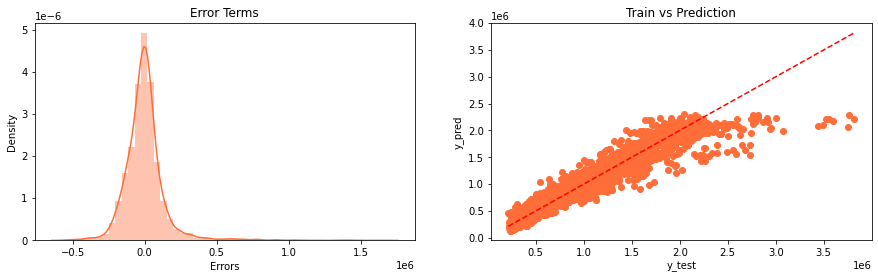

-----Test Set Metrics-----
R-squared                         :  0.9259969117585937
Root Mean Squared Error           :  148678.3546173368
Explained Variance Score          :  0.9261464625678785
Mean Absolute Error               :  92726.06885763565
Mean Squared Error                :  23389596412.635403
Mean Absolute Percentage Error    :  0.09356260005949268
Mean Squared Logarithmic Error    :  0.017959051481191313 

-----Test Set Plots-----


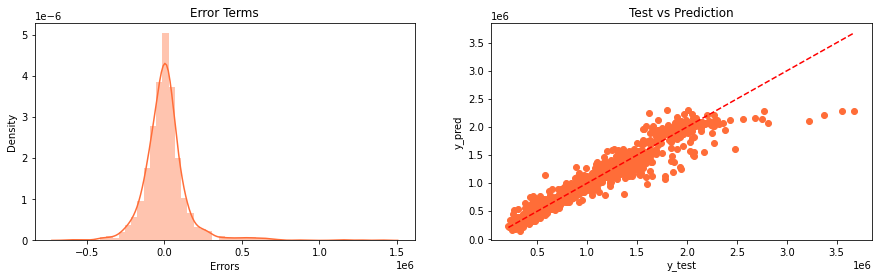

In [83]:
LLR = Lasso().fit(X_train_std,y_train)
pred_train = LLR.predict(X_train_std)
pred_test = LLR.predict(X_test_std)

model_evaluation_df.loc['Lasso Regression', : ] = (me.regression_evaluation('Lasso Regression',
                                                                            y_test, pred_test, 
                                                                            y_train, pred_train)).values[0]

## ElasticNet Regression

---------------------------------------- ElasticNET Regression ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.8321279182787107
Root Mean Squared Error           :  234044.3675615403
Explained Variance Score          :  0.8321279182787108
Mean Absolute Error               :  174920.08632846278
Mean Squared Error                :  54776765987.28138
Mean Absolute Percentage Error    :  0.23818554770754022
Mean Squared Logarithmic Error    :  0.07448784932194219 

-----Train Set Plots-----


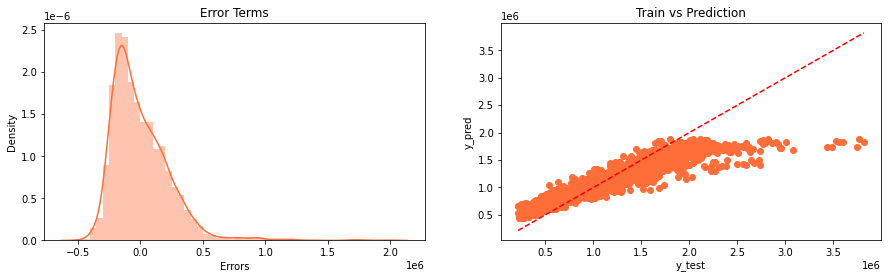

-----Test Set Metrics-----
R-squared                         :  0.8257692590877556
Root Mean Squared Error           :  234044.3675615403
Explained Variance Score          :  0.8258293995427237
Mean Absolute Error               :  173333.55772516335
Mean Squared Error                :  55067792567.22538
Mean Absolute Percentage Error    :  0.23390795510709403
Mean Squared Logarithmic Error    :  0.07399147059517458 

-----Test Set Plots-----


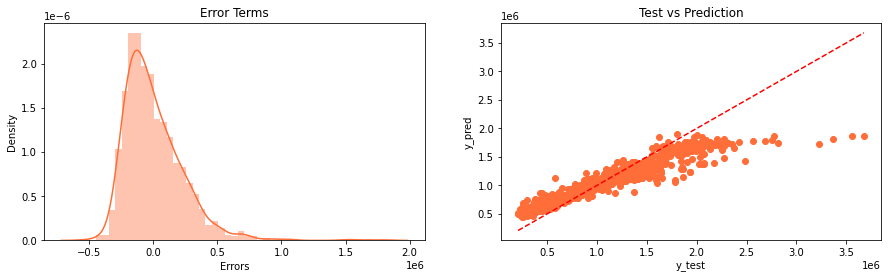

In [84]:
ENR = ElasticNet().fit(X_train_std,y_train)
pred_train = ENR.predict(X_train_std)
pred_test = ENR.predict(X_test_std)

model_evaluation_df.loc['ElasticNET Regression', : ] = (me.regression_evaluation('ElasticNET Regression',
                                                                            y_test, pred_test, 
                                                                            y_train, pred_train)).values[0]

## Support Vector Regression

---------------------------------------- SVR ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.9651290973395753
Root Mean Squared Error           :  106669.57156994709
Explained Variance Score          :  0.9652350421518024
Mean Absolute Error               :  55479.05714724104
Mean Squared Error                :  11378397498.916065
Mean Absolute Percentage Error    :  0.06031295554640262
Mean Squared Logarithmic Error    :  0.007679850454144084 

-----Train Set Plots-----


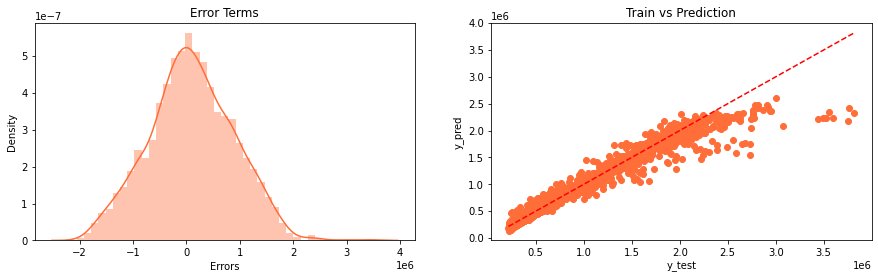

-----Test Set Metrics-----
R-squared                         :  0.9458661654761905
Root Mean Squared Error           :  106669.57156994709
Explained Variance Score          :  0.9458936532502009
Mean Absolute Error               :  73612.40961524092
Mean Squared Error                :  17109671661.943474
Mean Absolute Percentage Error    :  0.08227898752355207
Mean Squared Logarithmic Error    :  0.01566365651532654 

-----Test Set Plots-----


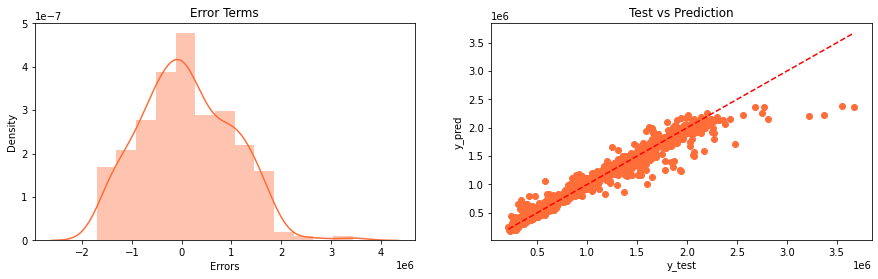

In [85]:
ss_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1))
y_tr_std = ss_y.transform(np.array(y_train).reshape(-1, 1))
y_te_std = ss_y.transform(np.array(y_test).reshape(-1, 1))

SVRm = SVR(C=1, epsilon=0.1, gamma=0.01).fit(X_train_std,y_tr_std)
pred_train = SVRm.predict(X_train_std)
pred_test = SVRm.predict(X_test_std)

pred_train = ss_y.inverse_transform(np.array(pred_train).reshape(-1, 1)).reshape(1,-1)[0]
pred_test = ss_y.inverse_transform(np.array(pred_test).reshape(-1, 1)).reshape(1,-1)[0]

model_evaluation_df.loc['SVR', : ] = (me.regression_evaluation('SVR',
                                                               y_test, pd.Series(pred_test), 
                                                               y_train, pd.Series(pred_train))).values[0]

## Stochastic Gradient Descent Regression

---------------------------------------- SGDRegressor ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.9285867025318562
Root Mean Squared Error           :  152650.59429349808
Explained Variance Score          :  0.9286640031427027
Mean Absolute Error               :  99593.39927688194
Mean Squared Error                :  23302203938.158146
Mean Absolute Percentage Error    :  0.10884556504723765
Mean Squared Logarithmic Error    :  0.022979397465324222 

-----Train Set Plots-----


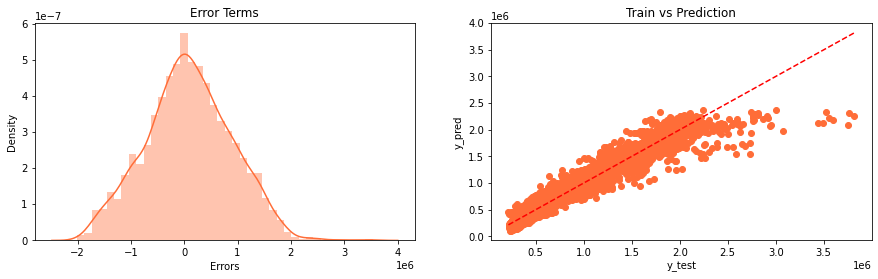

-----Test Set Metrics-----
R-squared                         :  0.9215252986367776
Root Mean Squared Error           :  152650.59429349808
Explained Variance Score          :  0.921538143827229
Mean Absolute Error               :  102100.17034964301
Mean Squared Error                :  24802905353.088535
Mean Absolute Percentage Error    :  0.10869629755330441
Mean Squared Logarithmic Error    :  0.02470123468683107 

-----Test Set Plots-----


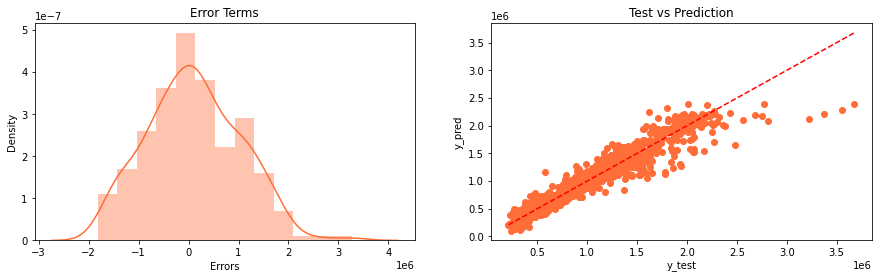

In [86]:
SGDR = SGDRegressor(loss='squared_epsilon_insensitive').fit(X_train_std,y_tr_std)
pred_train = SGDR.predict(X_train_std)
pred_test = SGDR.predict(X_test_std)

pred_train = ss_y.inverse_transform(np.array(pred_train).reshape(-1, 1)).reshape(1,-1)[0]
pred_test = ss_y.inverse_transform(np.array(pred_test).reshape(-1, 1)).reshape(1,-1)[0]

model_evaluation_df.loc['SGDRegressor', : ] = (me.regression_evaluation('SGDRegressor',
                                                                            y_test, pd.Series(pred_test), 
                                                                            y_train, pd.Series(pred_train))).values[0]

## Passive Agressive Regression 

---------------------------------------- PassiveAgressive Regression ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.9198201426501719
Root Mean Squared Error           :  161748.99674653672
Explained Variance Score          :  0.9218415696384511
Mean Absolute Error               :  81276.2819493165
Mean Squared Error                :  26162737948.51115
Mean Absolute Percentage Error    :  0.07546294313510059
Mean Squared Logarithmic Error    :  0.0150144091572364 

-----Train Set Plots-----


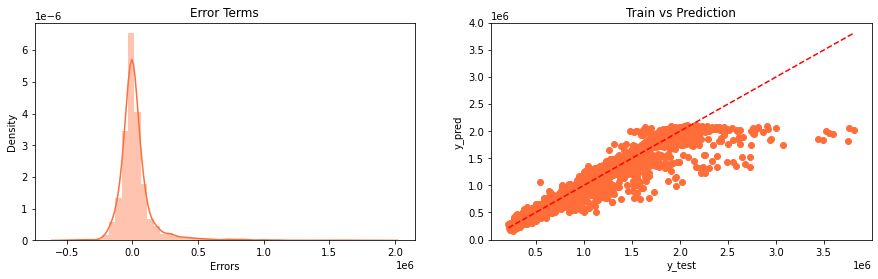

-----Test Set Metrics-----
R-squared                         :  0.9127071710432737
Root Mean Squared Error           :  161748.99674653672
Explained Variance Score          :  0.915636971194129
Mean Absolute Error               :  85741.94061015236
Mean Squared Error                :  27589984249.77404
Mean Absolute Percentage Error    :  0.07805058877565747
Mean Squared Logarithmic Error    :  0.015825303011857174 

-----Test Set Plots-----


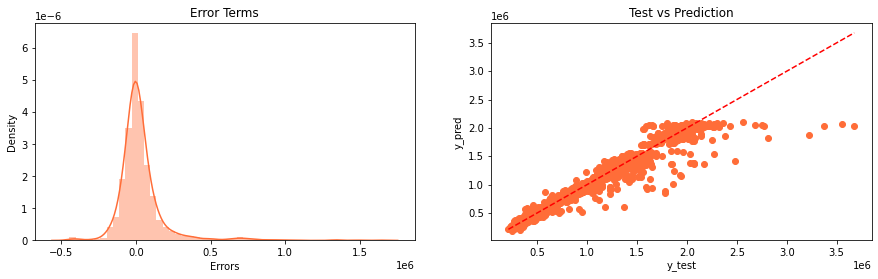

In [87]:
PAR = PassiveAggressiveRegressor().fit(X_train_std,y_train)
pred_train = PAR.predict(X_train_std)
pred_test = PAR.predict(X_test_std)

model_evaluation_df.loc['PassiveAgressive Regression', : ] = (me.regression_evaluation('PassiveAgressive Regression',
                                                                            y_test, pred_test, 
                                                                            y_train, pred_train)).values[0]

## Tweedie Regression

---------------------------------------- Tweedie Regression ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.9389795819276716
Root Mean Squared Error           :  141106.34587476528
Explained Variance Score          :  0.938979581927675
Mean Absolute Error               :  83601.73563968141
Mean Squared Error                :  19911000846.12889
Mean Absolute Percentage Error    :  0.08074164268540347
Mean Squared Logarithmic Error    :  0.012605002260501205 

-----Train Set Plots-----


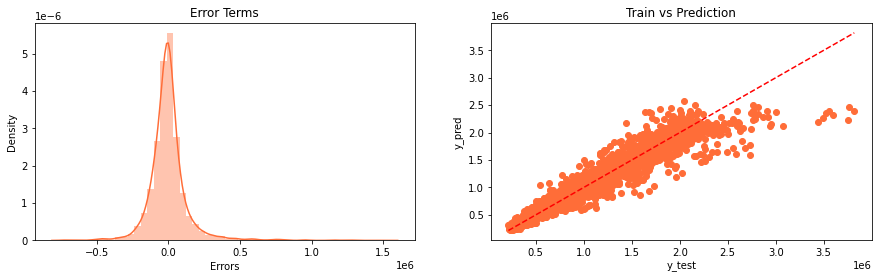

-----Test Set Metrics-----
R-squared                         :  0.9318772793898218
Root Mean Squared Error           :  141106.34587476528
Explained Variance Score          :  0.9319552273330948
Mean Absolute Error               :  87577.29213179633
Mean Squared Error                :  21531033088.849728
Mean Absolute Percentage Error    :  0.0828897696671261
Mean Squared Logarithmic Error    :  0.01354380356616658 

-----Test Set Plots-----


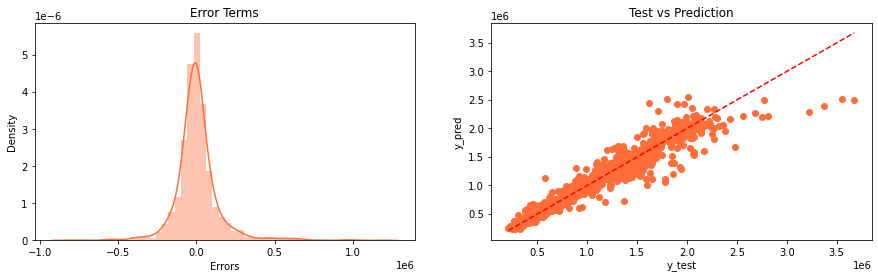

In [88]:
from sklearn.linear_model import TweedieRegressor

TR = TweedieRegressor(power=1).fit(X_train_std,y_train)
pred_train = TR.predict(X_train_std)
pred_test = TR.predict(X_test_std)

model_evaluation_df.loc['Tweedie Regression', : ] = (me.regression_evaluation('Tweedie Regression',
                                                                            y_test, pred_test, 
                                                                            y_train, pred_train)).values[0]

In [57]:
#from sklearn.linear_model import QuantileRegressor
#
#qntl = QuantileRegressor().fit(X_train_std,y_train)
#pred_train = qntl.predict(X_train_std)
#pred_test = qntl.predict(X_test_std)
#
#model_evaluation_df.loc['Quantile Regression', : ] = (me.regression_evaluation('Quantile Regression',
#                                                                            y_test, pred_test, 
#                                                                            y_train, pred_train)).values[0]

In [89]:
px.bar(data_frame=model_evaluation_df, 
       x=model_evaluation_df.index, 
       y=['train_R2', 'test_R2'], 
       barmode='group', 
       labels={'index':'Model Name', 'value':'R-Squared', 'variable':'Data'},
       color_discrete_sequence=px.colors.qualitative.Pastel, 
       custom_data=[model_evaluation_df['train_MSE'], model_evaluation_df['test_MSE']]
      )

In [61]:
X_tr_null = X_tr_org.copy()
X_te_null = X_te_org.copy()
for k,v in iqr_dict.items():
    iqr = v[1]-v[0]
    X_tr_null[k] = np.where((X_tr_null[k]>=v[0]-(1.5*iqr)) & (X_tr_null[k]<=v[1]+(1.5*iqr)), X_tr_null[k], np.nan)
    X_te_null[k] = np.where((X_te_null[k]>=v[0]-(1.5*iqr)) & (X_te_null[k]<=v[1]+(1.5*iqr)), X_te_null[k], np.nan)

In [62]:
X_tr_null.isnull().sum()[X_tr_null.isnull().sum()>0]

temperature       1
unemployment    400
dtype: int64

In [63]:
X_te_null.isnull().sum()[X_te_null.isnull().sum()>0]

temperature      1
unemployment    94
dtype: int64

In [68]:
imputer = KNNImputer().fit(X_tr_null)
X_tr_knn_imputed = imputer.transform(X_tr_null)
X_te_knn_imputed = imputer.transform(X_te_null)

In [69]:
sc2 = StandardScaler().fit(X_tr_knn_imputed)
X_tr_knn_imputed = sc2.transform(X_tr_knn_imputed)
X_te_knn_imputed = sc2.transform(X_te_knn_imputed)

### Linear Regression on KNN Imputed dataset

---------------------------------------- Linear Regression KNN imputed ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.9315577398287707
Root Mean Squared Error           :  147772.4161769399
Explained Variance Score          :  0.9315577424853794
Mean Absolute Error               :  90257.54666306046
Mean Squared Error                :  21836686982.770733
Mean Absolute Percentage Error    :  0.0953843349408382
Mean Squared Logarithmic Error    :  0.018570561956077723 

-----Train Set Plots-----


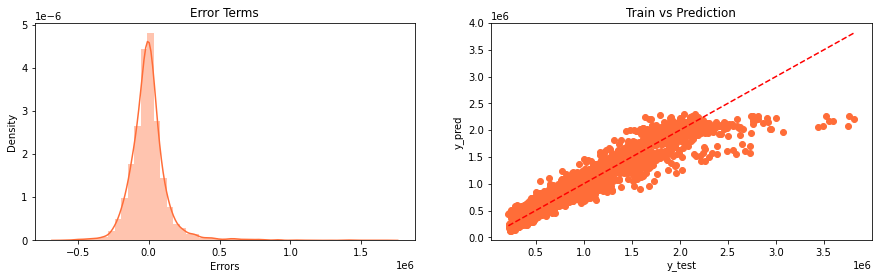

-----Test Set Metrics-----
R-squared                         :  0.9285391701874587
Root Mean Squared Error           :  147772.4161769399
Explained Variance Score          :  0.9285397788348934
Mean Absolute Error               :  90579.57279451434
Mean Squared Error                :  22586084018.209347
Mean Absolute Percentage Error    :  0.09193005511612669
Mean Squared Logarithmic Error    :  0.017448740431694032 

-----Test Set Plots-----


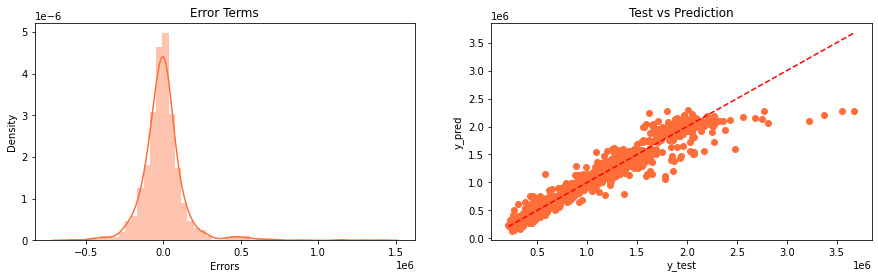

In [90]:
MLR = LinearRegression().fit(X_tr_knn_imputed,y_tr_org)
pred_train = MLR.predict(X_tr_knn_imputed)
pred_test = MLR.predict(X_te_knn_imputed)

model_evaluation_df.loc['Linear Regression KNN imputed', : ] = (me.regression_evaluation('Linear Regression KNN imputed', 
                                                                                         y_te_org, pred_test, 
                                                                                         y_tr_org, pred_train)).values[0]

### SVR on KNN Imputed Dataset

---------------------------------------- SVR KNN Imputed ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.9656213662804837
Root Mean Squared Error           :  104731.06248351884
Explained Variance Score          :  0.9657450396172775
Mean Absolute Error               :  54685.553450738706
Mean Squared Error                :  10968595448.926725
Mean Absolute Percentage Error    :  0.05927248182665576
Mean Squared Logarithmic Error    :  0.007393326595147135 

-----Train Set Plots-----


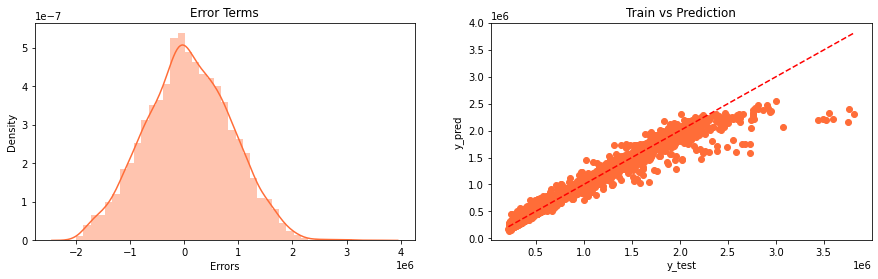

-----Test Set Metrics-----
R-squared                         :  0.9536241263261555
Root Mean Squared Error           :  104731.06248351884
Explained Variance Score          :  0.9536690066221343
Mean Absolute Error               :  66772.89103148093
Mean Squared Error                :  14657671649.811853
Mean Absolute Percentage Error    :  0.0705282973832175
Mean Squared Logarithmic Error    :  0.010676418931000757 

-----Test Set Plots-----


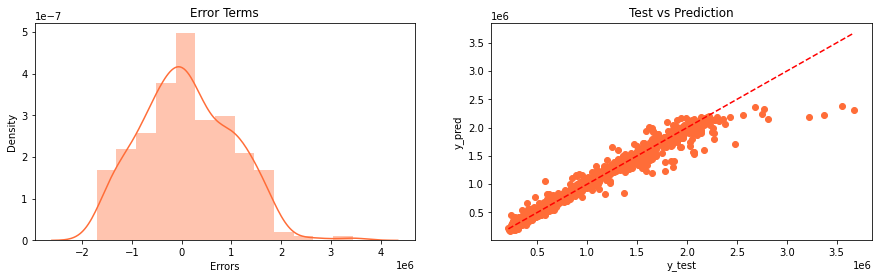

In [91]:
ss_y = StandardScaler().fit(np.array(y_tr_org).reshape(-1, 1))
y_tr_std = ss_y.transform(np.array(y_tr_org).reshape(-1, 1))
y_te_std = ss_y.transform(np.array(y_te_org).reshape(-1, 1))

SVRm = SVR(C=1, epsilon=0.1, gamma=0.01).fit(X_tr_knn_imputed,y_tr_std)
pred_train = SVRm.predict(X_tr_knn_imputed)
pred_test = SVRm.predict(X_te_knn_imputed)

pred_train = ss_y.inverse_transform(np.array(pred_train).reshape(-1, 1)).reshape(1,-1)[0]
pred_test = ss_y.inverse_transform(np.array(pred_test).reshape(-1, 1)).reshape(1,-1)[0]

model_evaluation_df.loc['SVR KNN Imputed', : ] = (me.regression_evaluation('SVR KNN Imputed',
                                                               y_te_org, pd.Series(pred_test), 
                                                               y_tr_org, pd.Series(pred_train))).values[0]

<AxesSubplot:xlabel='weekly_sales', ylabel='Count'>

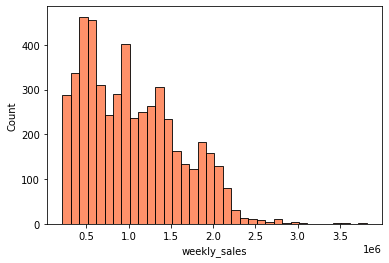

In [92]:
sns.histplot(y_tr_org)

<AxesSubplot:xlabel='weekly_sales', ylabel='Count'>

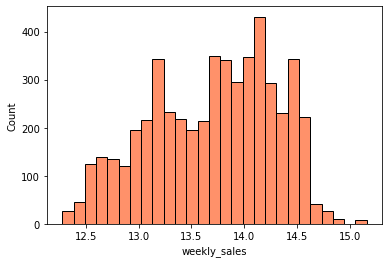

In [79]:
sns.histplot(np.log(y_tr_org))

### SVR on KNN Imputed X and log transformed y

---------------------------------------- SVR KNN Imputed Log ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.9745476171635021
Root Mean Squared Error           :  90114.65543225211
Explained Variance Score          :  0.9747206069972294
Mean Absolute Error               :  49681.18449560931
Mean Squared Error                :  8120651123.673526
Mean Absolute Percentage Error    :  0.0461148672705383
Mean Squared Logarithmic Error    :  0.004253996644246125 

-----Train Set Plots-----


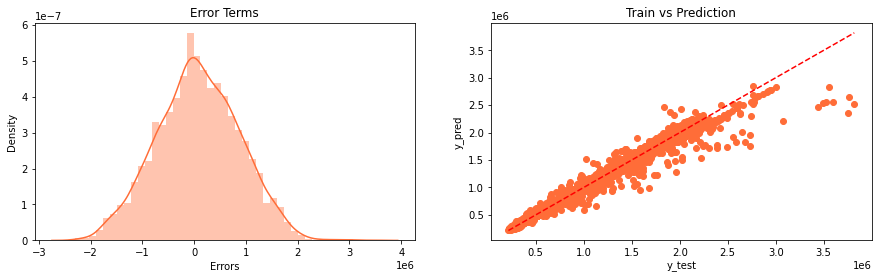

-----Test Set Metrics-----
R-squared                         :  0.9644905229618759
Root Mean Squared Error           :  90114.65543225211
Explained Variance Score          :  0.9646999957104101
Mean Absolute Error               :  61536.14692010407
Mean Squared Error                :  11223211848.080076
Mean Absolute Percentage Error    :  0.05874899802918602
Mean Squared Logarithmic Error    :  0.0072974269482894896 

-----Test Set Plots-----


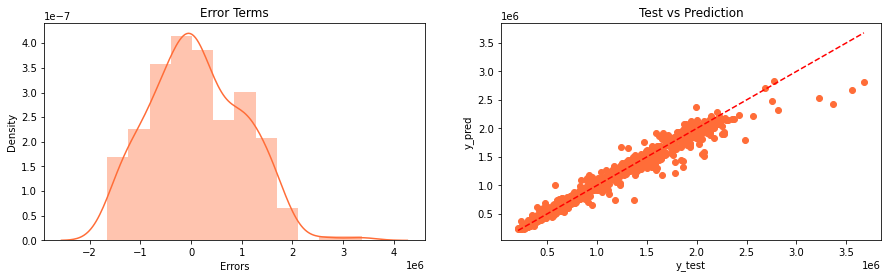

In [123]:
y_tr_log = np.log(y_tr_org)
y_te_log = np.log(y_te_org)

ss_y = StandardScaler().fit(np.array(y_tr_log).reshape(-1, 1))
y_tr_std = ss_y.transform(np.array(y_tr_log).reshape(-1, 1))
y_te_std = ss_y.transform(np.array(y_te_log).reshape(-1, 1))

SVRm = SVR(C=1, epsilon=0.1, gamma=0.01).fit(X_tr_knn_imputed,y_tr_std)
pred_train = SVRm.predict(X_tr_knn_imputed)
pred_test = SVRm.predict(X_te_knn_imputed)

pred_train = np.exp(ss_y.inverse_transform(np.array(pred_train).reshape(-1, 1)).reshape(1,-1)[0])
pred_test = np.exp(ss_y.inverse_transform(np.array(pred_test).reshape(-1, 1)).reshape(1,-1)[0])

model_evaluation_df.loc['SVR KNN Imputed Log', : ] = (me.regression_evaluation('SVR KNN Imputed Log',
                                                               y_te_org, pd.Series(pred_test), 
                                                               y_tr_org, pd.Series(pred_train))).values[0]

In [95]:
px.bar(data_frame=model_evaluation_df, 
       x=model_evaluation_df.index, 
       y=['train_R2', 'test_R2'], 
       barmode='group', 
       labels={'index':'Model Name', 'value':'R2', 'variable':'Data'},
       color_discrete_sequence=px.colors.qualitative.Pastel
      )

In [94]:
px.bar(data_frame=model_evaluation_df, 
       x=model_evaluation_df.index, 
       y=['train_MSE', 'test_MSE'], 
       barmode='group', 
       labels={'index':'Model Name', 'value':'MSE', 'variable':'Data'},
       color_discrete_sequence=px.colors.qualitative.Pastel
      )

In [98]:
from missingpy import MissForest

### SVR on MissForest Imputed X

In [99]:
imputer = MissForest().fit(X_tr_null)
X_tr_mf_imputed = imputer.transform(X_tr_null)
X_te_mf_imputed = imputer.transform(X_te_null)

sc2 = StandardScaler().fit(X_tr_mf_imputed)
X_tr_mf_imputed = sc2.transform(X_tr_mf_imputed)
X_te_mf_imputed = sc2.transform(X_te_mf_imputed)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2


---------------------------------------- SVR MF Imputed ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.9656232505517202
Root Mean Squared Error           :  104728.19232244247
Explained Variance Score          :  0.9657397153330396
Mean Absolute Error               :  54703.12591084845
Mean Squared Error                :  10967994267.126497
Mean Absolute Percentage Error    :  0.059247303215734376
Mean Squared Logarithmic Error    :  0.007395297677224435 

-----Train Set Plots-----


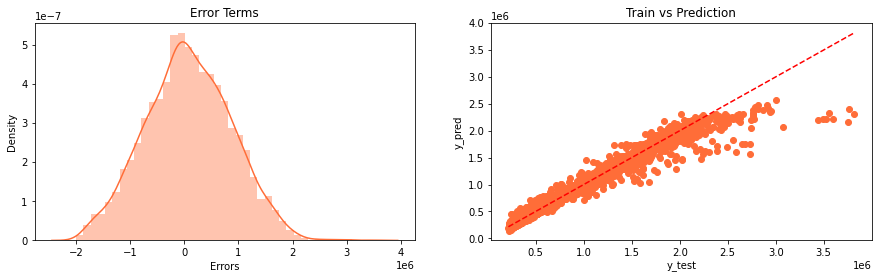

-----Test Set Metrics-----
R-squared                         :  0.953997445032972
Root Mean Squared Error           :  104728.19232244247
Explained Variance Score          :  0.9540272325968844
Mean Absolute Error               :  66570.99497075609
Mean Squared Error                :  14539679629.57017
Mean Absolute Percentage Error    :  0.0702493256137627
Mean Squared Logarithmic Error    :  0.01054284599527749 

-----Test Set Plots-----


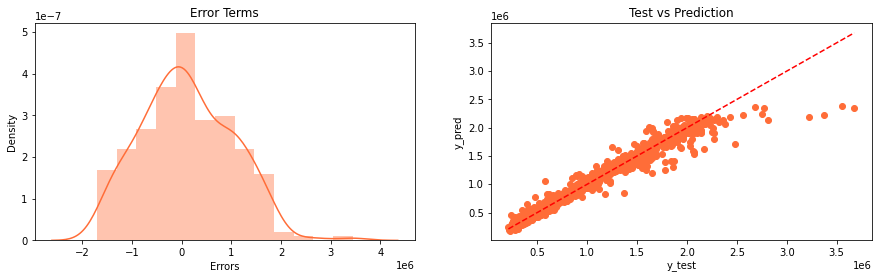

In [100]:
ss_y = StandardScaler().fit(np.array(y_tr_org).reshape(-1, 1))
y_tr_std = ss_y.transform(np.array(y_tr_org).reshape(-1, 1))
y_te_std = ss_y.transform(np.array(y_te_org).reshape(-1, 1))

SVRm = SVR(C=1, epsilon=0.1, gamma=0.01).fit(X_tr_mf_imputed,y_tr_std)
pred_train = SVRm.predict(X_tr_mf_imputed)
pred_test = SVRm.predict(X_te_mf_imputed)

pred_train = ss_y.inverse_transform(np.array(pred_train).reshape(-1, 1)).reshape(1,-1)[0]
pred_test = ss_y.inverse_transform(np.array(pred_test).reshape(-1, 1)).reshape(1,-1)[0]

model_evaluation_df.loc['SVR MF Imputed', : ] = (me.regression_evaluation('SVR MF Imputed',
                                                               y_te_org, pd.Series(pred_test), 
                                                               y_tr_org, pd.Series(pred_train))).values[0]

### SVR on MissForest Imputed X and log transformed y

---------------------------------------- SVR MF Imputed Log ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.9745605825385066
Root Mean Squared Error           :  90091.70042765273
Explained Variance Score          :  0.974718894965114
Mean Absolute Error               :  49738.84735671179
Mean Squared Error                :  8116514485.945924
Mean Absolute Percentage Error    :  0.04627639622664369
Mean Squared Logarithmic Error    :  0.00427184244559137 

-----Train Set Plots-----


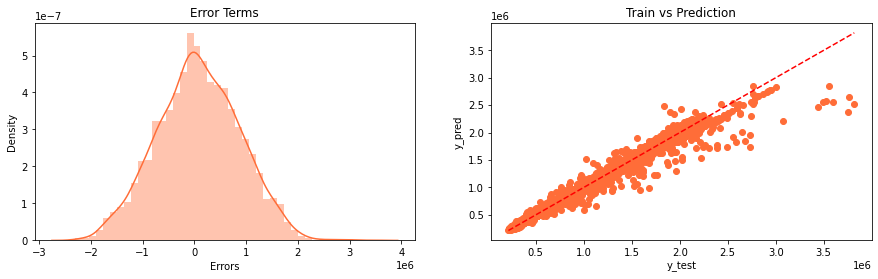

-----Test Set Metrics-----
R-squared                         :  0.9647318632903997
Root Mean Squared Error           :  90091.70042765273
Explained Variance Score          :  0.9649189004260361
Mean Absolute Error               :  61408.53747493673
Mean Squared Error                :  11146933235.708498
Mean Absolute Percentage Error    :  0.05861298027011343
Mean Squared Logarithmic Error    :  0.007282184102200426 

-----Test Set Plots-----


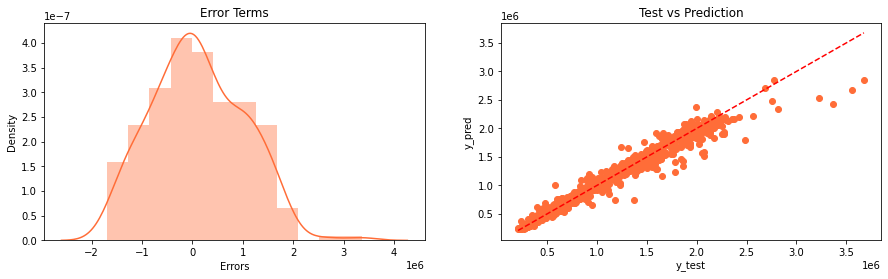

In [101]:
y_tr_log = np.log(y_tr_org)
y_te_log = np.log(y_te_org)

ss_y = StandardScaler().fit(np.array(y_tr_log).reshape(-1, 1))
y_tr_std = ss_y.transform(np.array(y_tr_log).reshape(-1, 1))
y_te_std = ss_y.transform(np.array(y_te_log).reshape(-1, 1))

SVRm = SVR(C=1, epsilon=0.1, gamma=0.01).fit(X_tr_mf_imputed,y_tr_std)
pred_train = SVRm.predict(X_tr_mf_imputed)
pred_test = SVRm.predict(X_te_mf_imputed)

pred_train = np.exp(ss_y.inverse_transform(np.array(pred_train).reshape(-1, 1)).reshape(1,-1)[0])
pred_test = np.exp(ss_y.inverse_transform(np.array(pred_test).reshape(-1, 1)).reshape(1,-1)[0])

model_evaluation_df.loc['SVR MF Imputed Log', : ] = (me.regression_evaluation('SVR MF Imputed Log',
                                                               y_te_org, pd.Series(pred_test), 
                                                               y_tr_org, pd.Series(pred_train))).values[0]

# Cross Validation & Grid Search

In [104]:
from sklearn.model_selection import cross_val_score,KFold

kf=KFold(n_splits=5)
score=cross_val_score(SVRm,X_tr_mf_imputed,y_tr_std,cv=kf)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Cross Validation Scores are [0.97838242 0.96974065 0.97757562 0.97665148 0.9798436 ]
Average Cross Validation score :0.9764387533652394


In [105]:
parameters = {'C':[1, 10], 'epsilon':[1, 0.1, 0.01, 0.001], 'gamma':[1, 0.1, 0.01, 0.001]}

In [107]:
from sklearn.model_selection import GridSearchCV

In [108]:
reg = GridSearchCV(SVRm, parameters, verbose=2, scoring='neg_mean_squared_error')
reg.fit(X_tr_mf_imputed, y_tr_std)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ............................C=1, epsilon=1, gamma=1; total time=   0.7s
[CV] END ............................C=1, epsilon=1, gamma=1; total time=   0.7s
[CV] END ............................C=1, epsilon=1, gamma=1; total time=   0.7s
[CV] END ............................C=1, epsilon=1, gamma=1; total time=   0.7s
[CV] END ............................C=1, epsilon=1, gamma=1; total time=   0.7s
[CV] END ..........................C=1, epsilon=1, gamma=0.1; total time=   0.5s
[CV] END ..........................C=1, epsilon=1, gamma=0.1; total time=   0.6s
[CV] END ..........................C=1, epsilon=1, gamma=0.1; total time=   0.5s
[CV] END ..........................C=1, epsilon=1, gamma=0.1; total time=   0.5s
[CV] END ..........................C=1, epsilon=1, gamma=0.1; total time=   0.4s
[CV] END .........................C=1, epsilon=1, gamma=0.01; total time=   0.0s
[CV] END .........................C=1, epsilon=

[CV] END .........................C=10, epsilon=0.1, gamma=1; total time=   2.1s
[CV] END .........................C=10, epsilon=0.1, gamma=1; total time=   2.2s
[CV] END .........................C=10, epsilon=0.1, gamma=1; total time=   2.1s
[CV] END .........................C=10, epsilon=0.1, gamma=1; total time=   2.1s
[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   1.6s
[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   1.6s
[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   1.6s
[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   1.8s
[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   1.7s
[CV] END ......................C=10, epsilon=0.1, gamma=0.01; total time=   1.3s
[CV] END ......................C=10, epsilon=0.1, gamma=0.01; total time=   1.2s
[CV] END ......................C=10, epsilon=0.1, gamma=0.01; total time=   1.2s
[CV] END ...................

GridSearchCV(estimator=SVR(C=1, gamma=0.01),
             param_grid={'C': [1, 10], 'epsilon': [1, 0.1, 0.01, 0.001],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             scoring='neg_mean_squared_error', verbose=2)

In [113]:
reg.best_params_

{'C': 1, 'epsilon': 0.01, 'gamma': 0.01}

In [115]:
reg.best_score_

-0.02178011954333484

---------------------------------------- SVR MF Imputed Log GridSearch ----------------------------------------
-----Train Set Metrics-----
R-squared                         :  0.9776209354017247
Root Mean Squared Error           :  84499.11646327624
Explained Variance Score          :  0.977816546812587
Mean Absolute Error               :  33831.39879222958
Mean Squared Error                :  7140100683.074322
Mean Absolute Percentage Error    :  0.03155686225539451
Mean Squared Logarithmic Error    :  0.0037098239703198367 

-----Train Set Plots-----


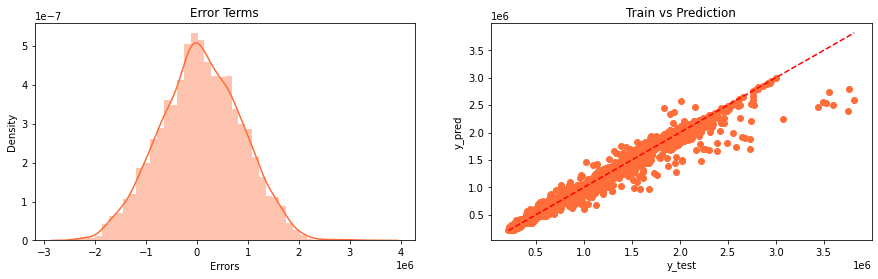

-----Test Set Metrics-----
R-squared                         :  0.967100840752562
Root Mean Squared Error           :  84499.11646327624
Explained Variance Score          :  0.9672576225559898
Mean Absolute Error               :  56954.75604233096
Mean Squared Error                :  10398188445.89848
Mean Absolute Percentage Error    :  0.05447081980578519
Mean Squared Logarithmic Error    :  0.00671731436882583 

-----Test Set Plots-----


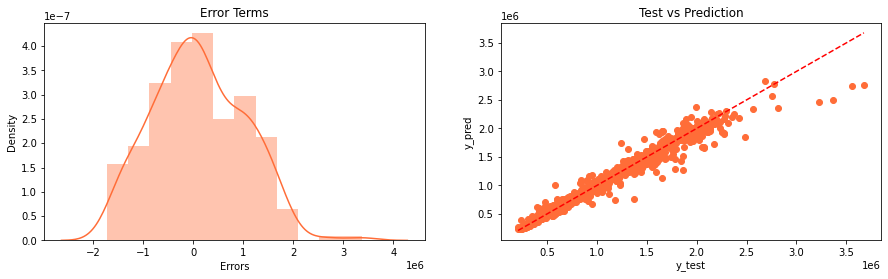

In [116]:
pred_train = reg.predict(X_tr_mf_imputed)
pred_test = reg.predict(X_te_mf_imputed)

pred_train = np.exp(ss_y.inverse_transform(np.array(pred_train).reshape(-1, 1)).reshape(1,-1)[0])
pred_test = np.exp(ss_y.inverse_transform(np.array(pred_test).reshape(-1, 1)).reshape(1,-1)[0])

model_evaluation_df.loc['SVR MF Imputed Log GridSearch', : ] = (me.regression_evaluation('SVR MF Imputed Log GridSearch',
                                                               y_te_org, pd.Series(pred_test), 
                                                               y_tr_org, pd.Series(pred_train))).values[0]

In [131]:
medf_filtered = model_evaluation_df.filter(regex='SVR', axis=0)

px.bar(data_frame=medf_filtered, 
       x=medf_filtered.index, 
       y=['train_MSE', 'test_MSE'], 
       barmode='group', 
       labels={'index':'Model Name', 'value':'MSE', 'variable':'Data'},
       color_discrete_sequence=px.colors.qualitative.Pastel
      )